Variance Inflation Factor

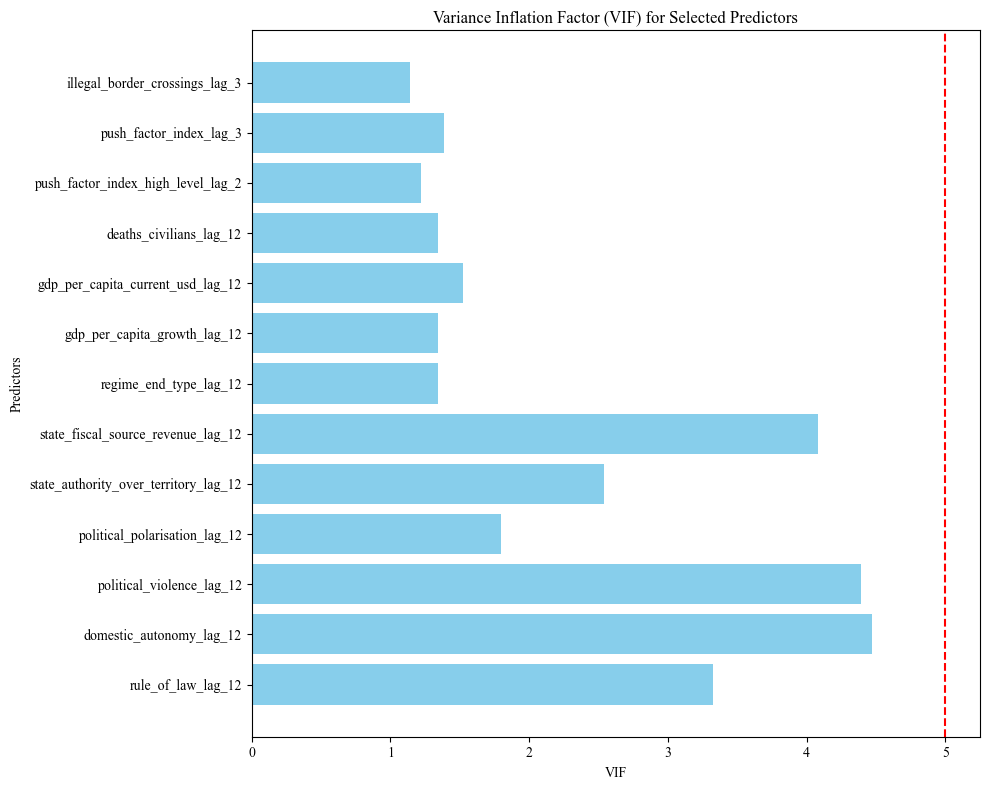

                                 Variable        VIF
0                               Intercept  78.721960
1          illegal_border_crossings_lag_3   1.142030
2                 push_factor_index_lag_3   1.384717
3      push_factor_index_high_level_lag_2   1.223823
4                 deaths_civilians_lag_12   1.344080
5       gdp_per_capita_current_usd_lag_12   1.521476
6            gdp_per_capita_growth_lag_12   1.342820
7                  regime_end_type_lag_12   1.339713
8      state_fiscal_source_revenue_lag_12   4.084685
9   state_authority_over_territory_lag_12   2.542666
10          political_polarisation_lag_12   1.798532
11              political_violence_lag_12   4.391264
12               domestic_autonomy_lag_12   4.471755
13                     rule_of_law_lag_12   3.328098


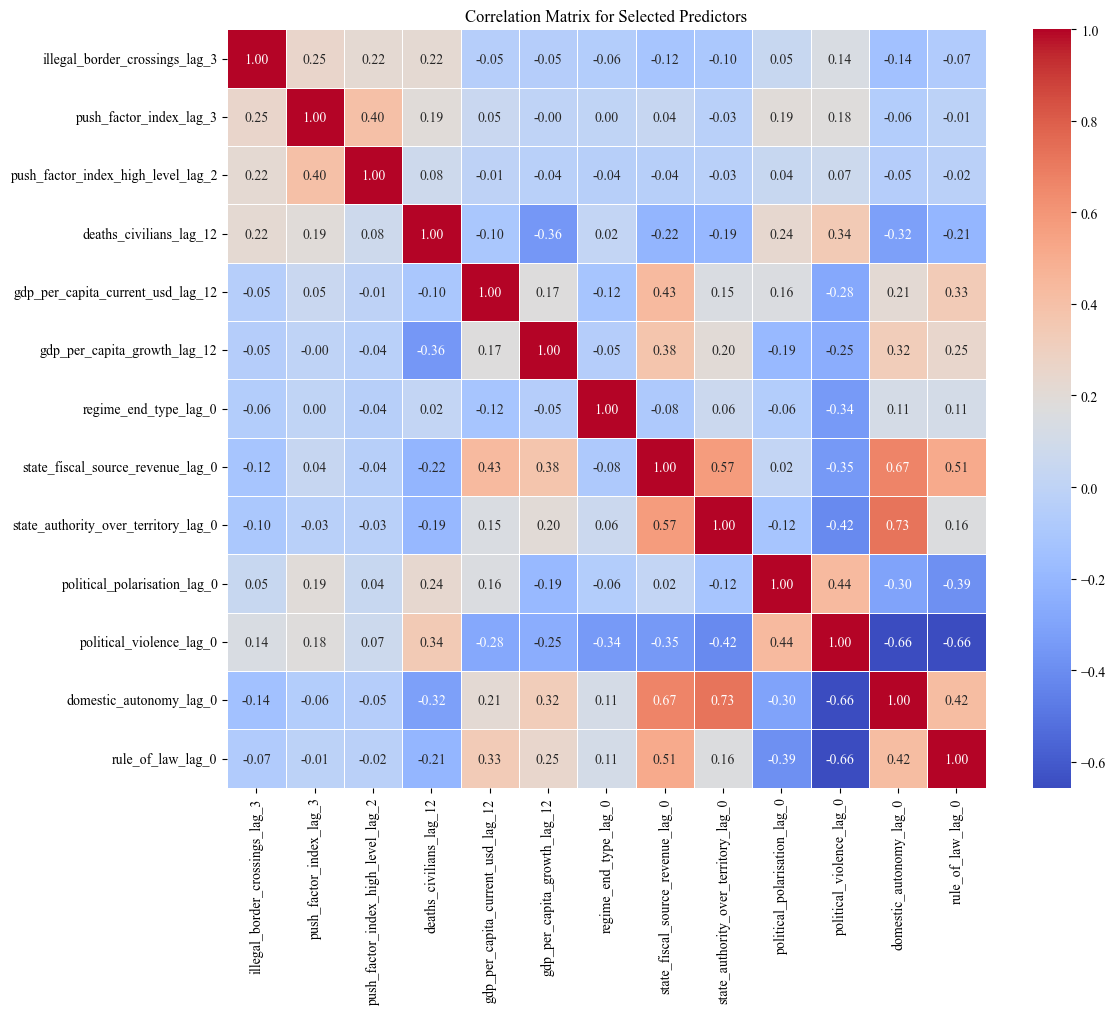

                                      illegal_border_crossings_lag_3  \
illegal_border_crossings_lag_3                              1.000000   
push_factor_index_lag_3                                     0.249600   
push_factor_index_high_level_lag_2                          0.220356   
deaths_civilians_lag_12                                     0.218885   
gdp_per_capita_current_usd_lag_12                          -0.047238   
gdp_per_capita_growth_lag_12                               -0.049993   
regime_end_type_lag_0                                      -0.056406   
state_fiscal_source_revenue_lag_0                          -0.117103   
state_authority_over_territory_lag_0                       -0.097258   
political_polarisation_lag_0                                0.046677   
political_violence_lag_0                                    0.141845   
domestic_autonomy_lag_0                                    -0.144131   
rule_of_law_lag_0                                          -0.07

In [24]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define the output directory
# The directory where the output files (plots, tables) will be saved.
output_dir = "GHVT6_Outputs"
os.makedirs(output_dir, exist_ok=True)

# Load the dataset
# Reading the data from a CSV file into a pandas DataFrame.
data = pd.read_csv("final_thesis_data.csv")
data['year_month'] = pd.to_datetime(data['year_month'])  # Convert 'year_month' column to datetime format.
data = data.sort_values(by=['country', 'year_month'])  # Sort the data for better handling of time series.

# Aggregate data by country, year_month, sex, and age_group
# Aggregating the data to ensure we have a sum of relevant metrics across groups.
data_agg = data.groupby(['country', 'year_month', 'sex', 'age_group']).sum().reset_index()

# Define the variables and their corresponding lags
# This dictionary defines which variables to lag and by how many months.
variables_to_lag = {
    "illegal_border_crossings": [3],
    "push_factor_index": [3],
    "push_factor_index_high_level": [2],
    "deaths_civilians": [12],
    "gdp_per_capita_current_usd": [12],
    "gdp_per_capita_growth": [12],
    "regime_end_type": [0],  # These variables are actually lagged by 12 months in the preprocessing step (see original raw data and corresponding R script).
    "state_fiscal_source_revenue": [0],
    "state_authority_over_territory": [0],
    "political_polarisation": [0],
    "political_violence": [0],
    "domestic_autonomy": [0],
    "rule_of_law": [0],
}

# Create lagged variables
# Generate the lagged variables based on the above dictionary.
lagged_vars = pd.DataFrame()
for var, lags in variables_to_lag.items():
    for lag in lags:
        lagged_var_name = f"{var}_lag_{lag}"
        if lag == 0:  # If lag is 0, just use the original variable
            lagged_vars[lagged_var_name] = data_agg[var]
        else:  # Apply the lag by shifting the data
            lagged_vars[lagged_var_name] = data_agg.groupby(['country', 'sex', 'age_group'])[var].shift(lag)

# Combine the original data with the new lagged variables
# This combines the newly created lagged variables with the original dataset.
data_agg = pd.concat([data_agg, lagged_vars], axis=1)

# Specify the predictors of interest
# These are the predictors that will be included in the VIF calculation and plot.
selected_predictors = [
    "illegal_border_crossings_lag_3", "push_factor_index_lag_3",
    "push_factor_index_high_level_lag_2", "deaths_civilians_lag_12",
    "gdp_per_capita_current_usd_lag_12", "gdp_per_capita_growth_lag_12",
    "regime_end_type_lag_0", "state_fiscal_source_revenue_lag_0",
    "state_authority_over_territory_lag_0", "political_polarisation_lag_0",
    "political_violence_lag_0", "domestic_autonomy_lag_0",
    "rule_of_law_lag_0",
]

# Subset the data to include only the selected predictors
# Create a subset of the data containing only the selected predictors.
X_selected = data_agg[selected_predictors]

# Drop rows with missing values before calculating VIF
# Ensure there are no missing values in the dataset as VIF calculation cannot handle NaNs.
X_selected = X_selected.dropna()

# Add a constant to the predictors set (needed for VIF calculation)
# The constant (intercept) is added to the dataset to include it in the VIF calculations.
X_selected = sm.add_constant(X_selected)
X_selected.rename(columns={"const": "Intercept"}, inplace=True)

# Calculate the VIF for the selected predictors
# VIF is calculated for each predictor including the intercept.
vif_df = pd.DataFrame()
vif_df["Variable"] = X_selected.columns
vif_df["VIF"] = [variance_inflation_factor(X_selected.values, i) for i in range(X_selected.shape[1])]

# Rename V-Dem variables that were actually lagged by 12 months in preprocessing
# manually correct the labels of variables that were erroneously labeled with '_lag_0'.
rename_dict = {
    "state_fiscal_source_revenue_lag_0": "state_fiscal_source_revenue_lag_12",
    "state_authority_over_territory_lag_0": "state_authority_over_territory_lag_12",
    "political_polarisation_lag_0": "political_polarisation_lag_12",
    "political_violence_lag_0": "political_violence_lag_12",
    "domestic_autonomy_lag_0": "domestic_autonomy_lag_12",
    "rule_of_law_lag_0": "rule_of_law_lag_12",
    "regime_end_type_lag_0": "regime_end_type_lag_12"
}
vif_df["Variable"] = vif_df["Variable"].replace(rename_dict)

# Remove the intercept from the DataFrame for plotting
# Exclude the intercept from the plot for a cleaner visualisation.
vif_df_plot = vif_df[vif_df["Variable"] != "Intercept"]

# Plot the VIF values without the intercept
# The VIF values are plotted using a horizontal bar chart, with a line marking the threshold of concern (VIF = 5).
plt.figure(figsize=(10, 8))
plt.barh(vif_df_plot['Variable'], vif_df_plot['VIF'], color='skyblue')

# Add a red dotted line at VIF = 5
plt.axvline(x=5, color='red', linestyle='--', linewidth=1.5)

plt.xlabel('VIF')
plt.ylabel('Predictors')
plt.title('Variance Inflation Factor (VIF) for Selected Predictors')
plt.gca().invert_yaxis()  # Show the highest VIF at the top
plt.tight_layout()

# Save the plot to the output directory
# The plot is saved in the specified output directory as a PNG file.
plt.savefig(f"{output_dir}/VIF_Selected_Predictors.png")
plt.show()

# Print the VIF data with the corrected labels
# Output the VIF data to the console for inspection.
print(vif_df)
